In [ ]:
!pip install tensorflow-gpu


In [ ]:
!nvidia-smi

Tue Jun  7 13:24:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@markdown <h3>← 0th Step. Run after entering the above code in your browser console (to prevent disconnection). </h>
#@markdown <h4>← function ClickConnect(){ console.log("Working"); document.querySelector("colab-connect-button").click() }setInterval(ClickConnect,6000)</h4>


import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


# Drive Mount and Path Selection

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:

# re-size all the images to this
IMAGE_SIZE = [200, 100]

train_path = '/content/gdrive/MyDrive/Rose/Train'
valid_path = '/content/gdrive/MyDrive/Rose/Test'

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [8]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

# Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


# VGG16

In [9]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
inception = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


# ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

inception = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


# Xception

In [ ]:

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

inception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


# Testing Model

In [10]:
#don't train existing weights

for layer in inception.layers:
    layer.trainable = False

In [11]:
# useful for getting number of output classes
folders = glob('/content/gdrive/MyDrive/Rose/Train/*')

In [12]:
# our layers - you can add more if you want
from keras.layers import Dropout
x = Flatten()(inception.output)

In [13]:
Y = Dense(len(folders), activation='softmax')(x)
prediction = Dropout(0.12)(Y)
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 50, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 50, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 50, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 25, 128)       0     

In [15]:

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Rose/Train',
                                                 target_size = (200, 100),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1550 images belonging to 5 classes.


In [18]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Rose/Test',
                                            target_size = (200, 100),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 387 images belonging to 5 classes.


In [19]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
49/49 [==============================] - 1065s 22s/step - loss: 2.4892 - accuracy: 0.6413 - val_loss: 0.3294 - val_accuracy: 0.9225
Epoch 2/20
49/49 [==============================] - 328s 7s/step - loss: 2.0580 - accuracy: 0.8639 - val_loss: 0.1529 - val_accuracy: 0.9897
Epoch 3/20
49/49 [==============================] - 326s 7s/step - loss: 1.8976 - accuracy: 0.8806 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 4/20
49/49 [==============================] - 324s 7s/step - loss: 1.9820 - accuracy: 0.8781 - val_loss: 0.0836 - val_accuracy: 1.0000
Epoch 5/20
49/49 [==============================] - 329s 7s/step - loss: 2.0786 - accuracy: 0.8710 - val_loss: 0.0444 - val_accuracy: 1.0000
Epoch 6/20
49/49 [==============================] - 325s 7s/step - loss: 1.9450 - accuracy: 0.8806 - val_loss: 0.0442 - val_accuracy: 1.0000
Epoch 7/20
49/49 [==============================] - 325s 7s/step - loss: 2.0915 - accuracy: 0.8710 - val_loss: 0.0316 - val_accuracy: 1.0000
Epoch 8/20


In [ ]:
result = model.evaluate(test_set)

# Plot

In [20]:
import matplotlib.pyplot as plt


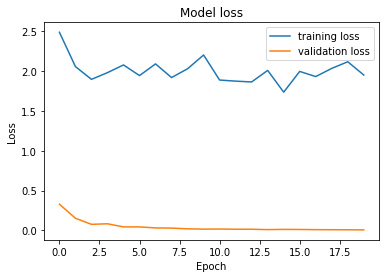

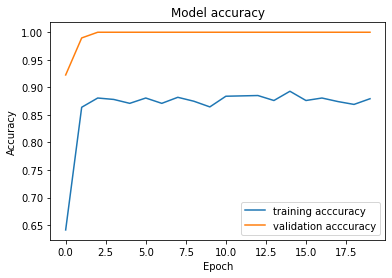

<Figure size 432x288 with 0 Axes>

In [21]:
# plot the loss
plt.plot(r.history['loss'], label='training loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='training acccuracy')
plt.plot(r.history['val_accuracy'], label='validation acccuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

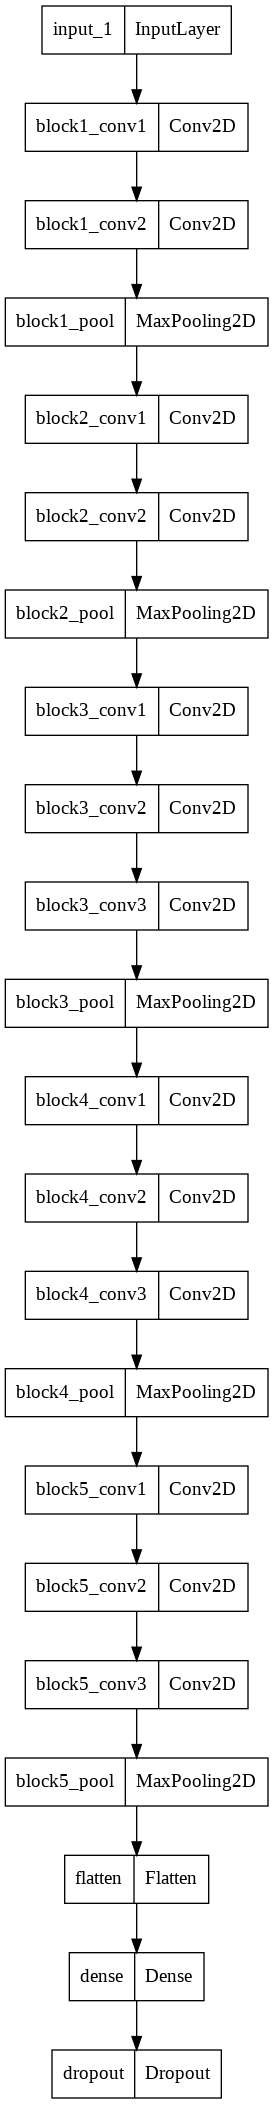

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [23]:
print(r.history['accuracy'])
print(r.history['val_accuracy'])


[0.6412903070449829, 0.8638709783554077, 0.8806451559066772, 0.8780645132064819, 0.8709677457809448, 0.8806451559066772, 0.8709677457809448, 0.8819354772567749, 0.8748387098312378, 0.8645161390304565, 0.8838709592819214, 0.8845161199569702, 0.885161280632019, 0.8761290311813354, 0.892903208732605, 0.8761290311813354, 0.8806451559066772, 0.874193549156189, 0.8690322637557983, 0.8793548345565796]
[0.9224806427955627, 0.9896640777587891, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [24]:
test_labels = test_set.classes
test_labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,

In [25]:
predictions = model.predict_generator(test_set, steps = len(test_set))
predictions.argmax(axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


array([0, 4, 4, 4, 3, 3, 1, 4, 2, 4, 3, 2, 3, 3, 3, 2, 1, 4, 3, 2, 0, 0,
       4, 2, 1, 3, 3, 3, 0, 4, 1, 1, 4, 3, 3, 1, 3, 0, 4, 0, 0, 4, 0, 4,
       2, 3, 0, 1, 2, 3, 3, 4, 0, 0, 2, 0, 1, 4, 4, 2, 4, 2, 3, 1, 4, 0,
       0, 4, 0, 3, 1, 1, 2, 2, 0, 2, 1, 3, 4, 4, 2, 3, 4, 3, 3, 4, 4, 3,
       1, 1, 4, 3, 1, 0, 0, 2, 4, 0, 2, 4, 1, 2, 4, 2, 1, 0, 1, 2, 0, 4,
       0, 0, 3, 4, 3, 4, 2, 4, 3, 2, 1, 4, 1, 0, 4, 1, 3, 0, 2, 4, 0, 4,
       4, 2, 3, 3, 0, 0, 4, 0, 4, 3, 1, 1, 4, 0, 0, 4, 3, 0, 3, 0, 1, 0,
       3, 2, 3, 4, 0, 0, 3, 1, 3, 3, 1, 4, 4, 2, 4, 4, 4, 2, 2, 1, 2, 2,
       2, 4, 2, 1, 0, 2, 1, 3, 2, 4, 2, 0, 2, 2, 3, 0, 2, 2, 1, 4, 4, 4,
       3, 1, 1, 0, 4, 2, 3, 2, 2, 0, 0, 4, 4, 2, 3, 4, 0, 1, 0, 0, 3, 2,
       2, 0, 3, 0, 2, 0, 2, 0, 0, 4, 1, 4, 2, 4, 2, 0, 0, 3, 4, 2, 1, 4,
       1, 1, 1, 1, 0, 0, 2, 4, 1, 3, 1, 2, 2, 4, 2, 2, 0, 2, 0, 2, 1, 2,
       1, 2, 2, 2, 3, 4, 1, 4, 2, 4, 3, 3, 0, 1, 4, 3, 1, 4, 3, 1, 2, 3,
       1, 0, 2, 4, 1, 0, 1, 2, 0, 1, 3, 4, 1, 1, 1,

In [26]:
from sklearn.metrics import confusion_matrix
print(len(test_labels))
print(len(predictions))
cm = confusion_matrix(test_labels  , predictions.argmax(axis = 1))

387
387


In [27]:
def plots(ims, figsize = (12,6), rows = 5, interp = False, titles = None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if(ims.shape[-1] != 3):
      ims = ims.transpose((0,2,3,1))
  f = plt.figure(figsize = figsize)
  cols = len(ims)
  for i in range(len(ims)):
    sp = f.add_subplot(rows,cols,i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i] ,fontsize = 16)
    plt.imshow(ims[i], interpolation = None if interp else 'none')

In [28]:
import itertools    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    # Only use the labels that appear in the data
    
    print(cm)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    
    for i,j in itertools.product(range(cm.shape[0]) , range(cm.shape[1]) ):
        plt.text(j , i , cm[i,j] , 
                  horizontalalignment = "center",
                  color = "white" if cm[i, j] > thresh else "black")

    #plt.tight.layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

[[16 12 13 19 18]
 [16 11 10 14 22]
 [18 10 23 12 15]
 [ 9 17 18  8 13]
 [19 23 14 12 25]]


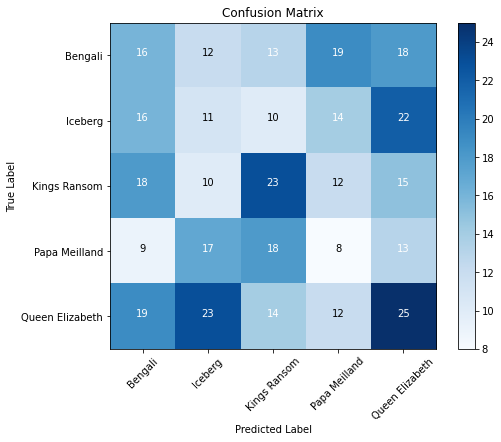

In [29]:
cm_plot_labels = ['Bengali' , 'Iceberg' , 'Kings Ransom', 'Papa Meilland', 'Queen Elizabeth']
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels  , predictions.argmax(axis = 1))

0.2144702842377261

In [31]:
from sklearn.metrics import classification_report
classification_report(test_labels  , predictions.argmax(axis = 1))

'              precision    recall  f1-score   support\n\n           0       0.21      0.21      0.21        78\n           1       0.15      0.15      0.15        73\n           2       0.29      0.29      0.29        78\n           3       0.12      0.12      0.12        65\n           4       0.27      0.27      0.27        93\n\n    accuracy                           0.21       387\n   macro avg       0.21      0.21      0.21       387\nweighted avg       0.21      0.21      0.21       387\n'

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr,tpr,th = roc_curve(test_labels  , predictions.argmax(axis = 1), pos_label =2)

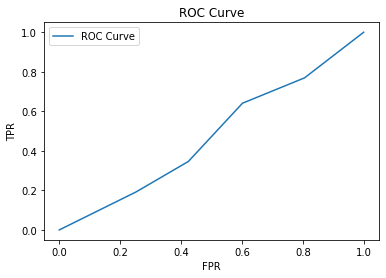

In [33]:
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(['ROC Curve'], loc='upper left')
plt.show()